**This notebook uses Facebook prophet to predict the future CO2 concentrations. This notebook was used with Google Colabs due to difficulties for local FBprophet installation.** 

In [1]:
# Install Libraries (This may need to be done first each time the notebook is used here.  Takes a few minutes to install)
from IPython.display import clear_output
try:
  !pip install pystan
  !pip install --upgrade git+https://github.com/jroakes/google-analytics.git
  !pip install fbprophet
except:
  pass
finally:
  clear_output()
  print('All Loaded')
  #clean geopandas install
#https://colab.research.google.com/drive/1tSmJmjD3sTI31Cg1UCIKiE10dBUmWUG7#scrollTo=AXNRLO1CixX9
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import googleanalytics as ga
from geopandas import GeoSeries
import random
from random import randrange
import geopandas as gpd
from shapely.geometry import Polygon
import pickle
import seaborn as sns
import datetime
from fbprophet.plot import add_changepoints_to_plot

All Loaded
Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 https://developer.download.nvidia.com/compute/cuda/rep

Mount google drive and read in excel files. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#import dataset with regions 
geo1= pd.read_excel('/content/drive/My Drive/DATA MPS/DATA606/MergedPoly1.xlsx')
geo2= pd.read_excel('/content/drive/My Drive/DATA MPS/DATA606/MergedPoly2.xlsx')


In [4]:
#concat the split excel files 
geo = pd.concat([geo1,geo2])
geo.drop(columns=geo.columns[0],inplace=True)
#make columns for facebook prophet 
geo['ds'] = geo.DS
geo['y'] = geo.Y

In [5]:
#print the latest datetime point for each ocean region 
i =geo.groupby(['Region'])
for group in i.groups:
  print(group)
  print(i.get_group(group)['ds'].max())

Arabian Sea
2007-04-27 00:00:00
Bay of Bengal
2016-01-08 00:00:00
Equatorial Atlantic
2019-05-08 00:00:00
Equatorial Pacific
2018-09-14 00:00:00
High-latitude North Atlantic
2017-05-21 00:00:00
Highlatitude North Pacific
2018-07-12 00:00:00
Med Sea
2013-05-20 00:00:00
Oligotrophic Indian
2018-01-11 00:00:00
Oligotrophic North Atlantic
2019-05-17 00:00:00
Oligotrophic North Pacific
2018-10-16 00:00:00
Oligotrophic South Atlantic
2019-05-04 00:00:00
Oligotrophic South Pacific
2017-01-11 00:00:00
Southern Ocean Atlantic
2019-04-10 00:00:00
Southern Ocean Indian
2018-02-19 00:00:00
Southern Ocean Pacific
2018-02-06 00:00:00


**FB prophet requires a datetime (DS) and a target (Y) column. The dataframe is converted to geopandas df to split into polygon regions**

I used geopandas function spatial join in the preivous notebook to find what cruise locations are within what ocean region. Run the data grouped by Region through the FB prophet API. 

https://geopandas.org/mergingdata.html

**Group by region and save a pickeled model to a dictionary of models (FB prophet)**

In [6]:
i =geo.groupby(['Region'])
models={}
for group in i.groups:
  print(group)
  m = Prophet() # FB prophet
  m.fit(i.get_group(group)) #fit fb prophet model 
  models[group] = m #save to dictionary 
 

Arabian Sea


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Bay of Bengal


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Equatorial Atlantic


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Equatorial Pacific
High-latitude North Atlantic


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Highlatitude North Pacific


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Med Sea


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Oligotrophic Indian


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Oligotrophic North Atlantic
Oligotrophic North Pacific


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


SystemError: ignored

**Pickle the FB prophet models for each region.**



In [ ]:
# for each model save pickle
for key in models.keys():
  pkl_path = "/content/drive/My Drive/DATA MPS/DATA606/FBprophetModels/" +key +".pkl"
  with open(pkl_path, "wb") as f:
    pickle.dump(models[key], f)


In [ ]:
forecast= {}
#predict next year 
for group in i.groups:
  fut= models[group].make_future_dataframe(periods=365)
  forecast[group]= models[group].predict(fut)
  forecast[group].to_pickle("/content/drive/My Drive/DATA MPS/DATA606/FBprophetModels/Future/" +group +".pkl")

**Load pickled model and predicted values back in**

In [7]:
i =geo.groupby(['Region'])
models,futures ={},{}
for key in i.groups:
  with open(("/content/drive/My Drive/DATA MPS/DATA606/FBprophetModels/" +key +".pkl"), 'rb') as f:
    models[key] = pickle.load(f)
    futures[key]= pd.read_pickle("/content/drive/My Drive/DATA MPS/DATA606/FBprophetModels/Future/" +group +".pkl")

In [ ]:
futures[li[9]]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1977-12-24,2279.721944,2115.753499,2398.311292,2279.721944,2279.721944,-20.315175,-20.315175,-20.315175,1.858201,1.858201,1.858201,-22.173375,-22.173375,-22.173375,0.0,0.0,0.0,2259.406770
1,1977-12-25,2279.710331,2119.218931,2390.693675,2279.710331,2279.710331,-23.125391,-23.125391,-23.125391,-1.019078,-1.019078,-1.019078,-22.106312,-22.106312,-22.106312,0.0,0.0,0.0,2256.584940
2,1977-12-26,2279.698717,2119.579037,2395.509126,2279.698717,2279.698717,-21.234513,-21.234513,-21.234513,0.830752,0.830752,0.830752,-22.065265,-22.065265,-22.065265,0.0,0.0,0.0,2258.464204
3,1977-12-27,2279.687103,2116.587996,2382.145420,2279.687103,2279.687103,-25.881167,-25.881167,-25.881167,-3.772546,-3.772546,-3.772546,-22.108621,-22.108621,-22.108621,0.0,0.0,0.0,2253.805936
4,1977-12-29,2279.663875,2132.187192,2391.041334,2279.663875,2279.663875,-20.606560,-20.606560,-20.606560,2.031427,2.031427,2.031427,-22.637987,-22.637987,-22.637987,0.0,0.0,0.0,2259.057316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,2008-04-22,2288.326752,2118.498079,2383.591312,2288.182241,2288.497854,-33.446297,-33.446297,-33.446297,-3.772546,-3.772546,-3.772546,-29.673751,-29.673751,-29.673751,0.0,0.0,0.0,2254.880455
566,2008-04-23,2288.332990,2120.986821,2389.042748,2288.186302,2288.505183,-34.319636,-34.319636,-34.319636,-3.174157,-3.174157,-3.174157,-31.145479,-31.145479,-31.145479,0.0,0.0,0.0,2254.013354
567,2008-04-24,2288.339228,2133.606425,2389.120815,2288.190363,2288.512444,-30.913943,-30.913943,-30.913943,2.031427,2.031427,2.031427,-32.945371,-32.945371,-32.945371,0.0,0.0,0.0,2257.425285
568,2008-04-25,2288.345467,2125.337712,2393.946838,2288.194424,2288.519298,-31.843101,-31.843101,-31.843101,3.245400,3.245400,3.245400,-35.088502,-35.088502,-35.088502,0.0,0.0,0.0,2256.502366


## These plots show the past data and the Facebook prophet future predicted data. The performance of the FB prophet models is poor because daily data is expected by the API and the cruise data is concentrated to several weeks out of the year for ocean regions, with >1 year gaps in between years of observation for some regions. 

The x-axis range is set to the 

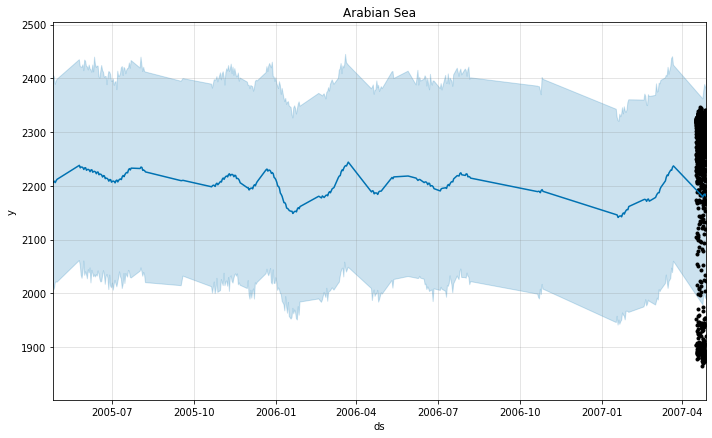

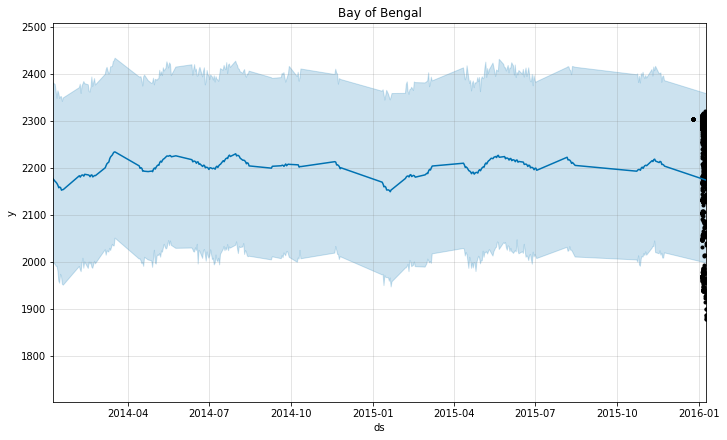

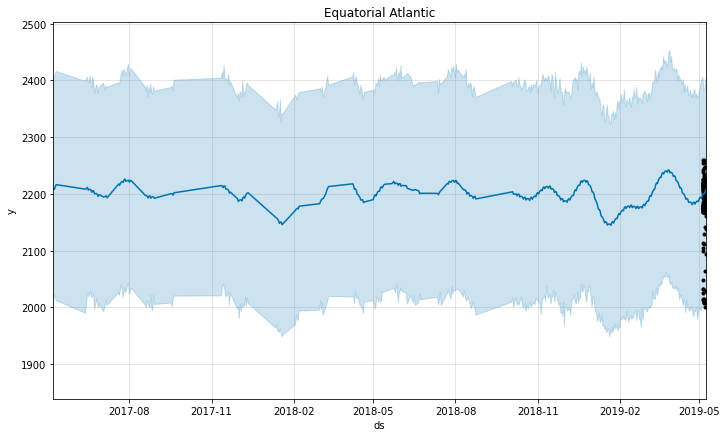

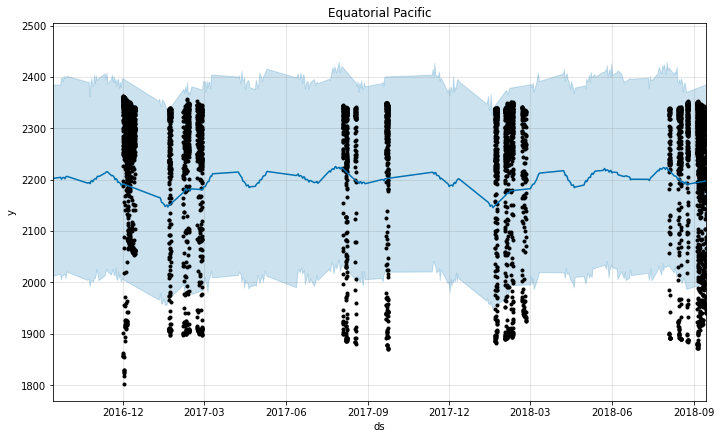

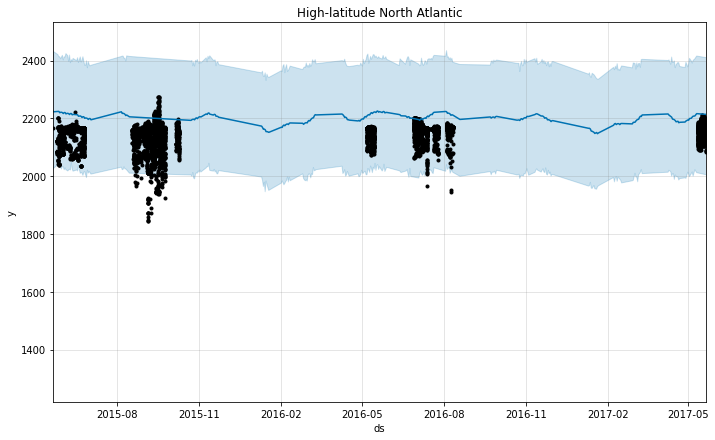

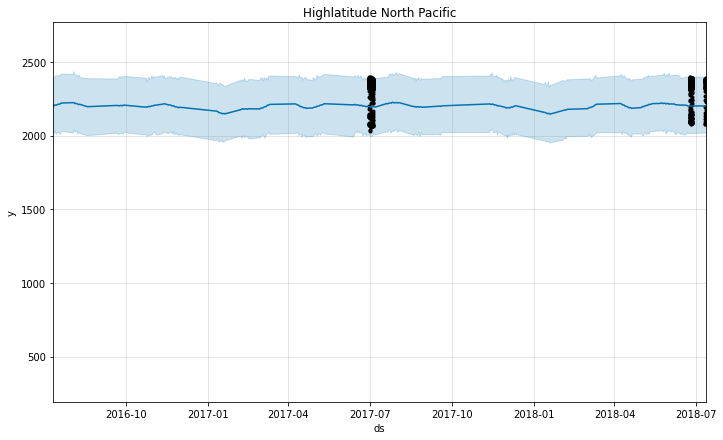

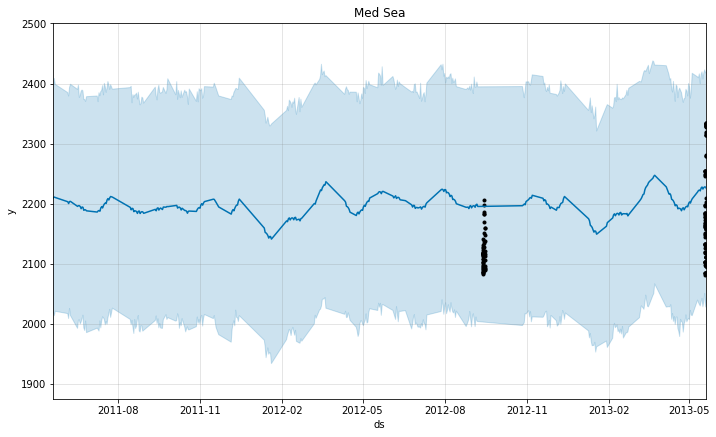

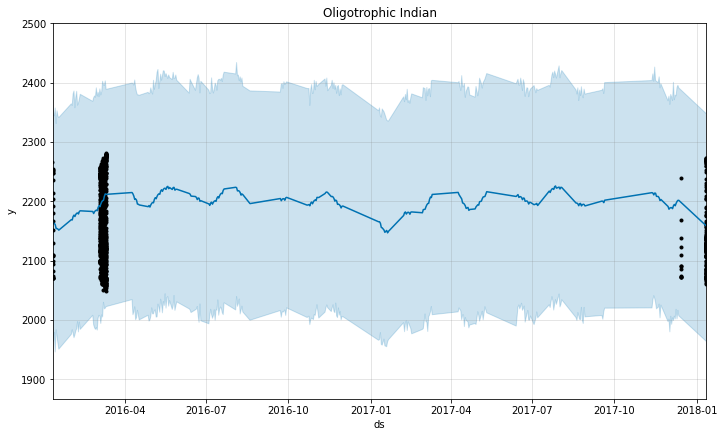

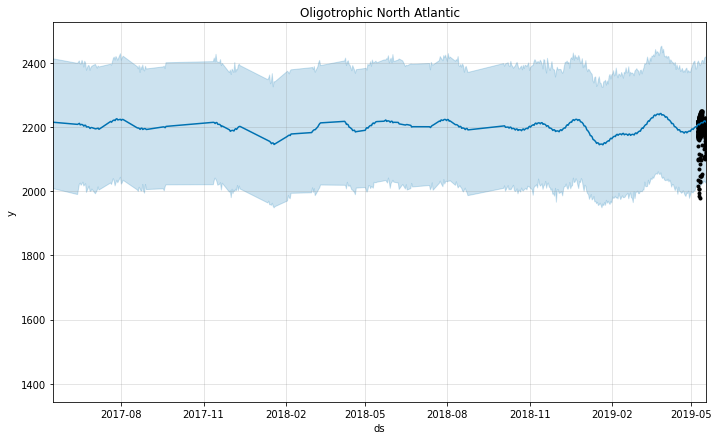

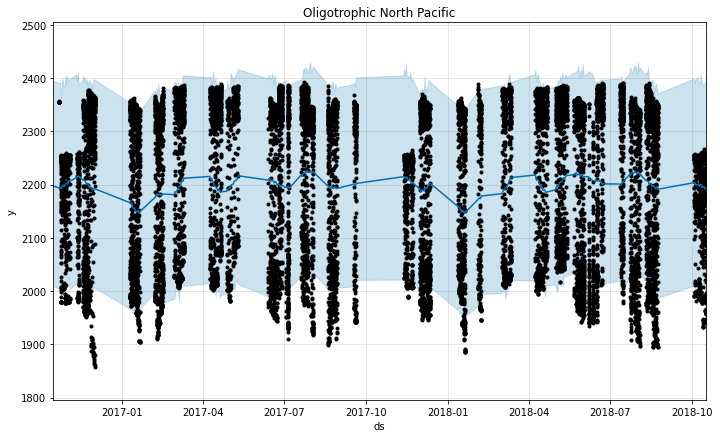

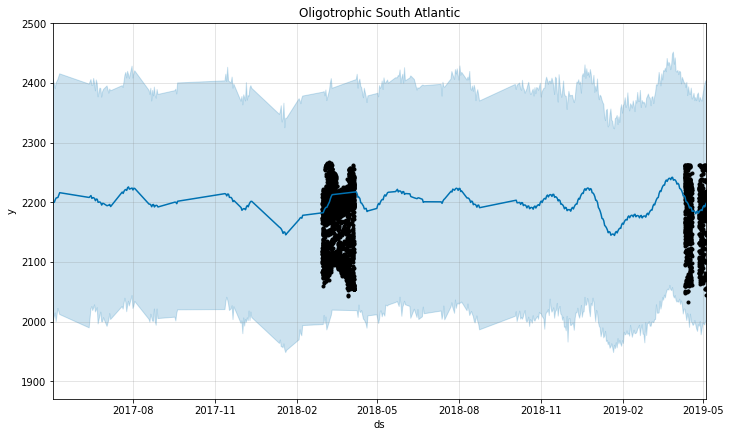

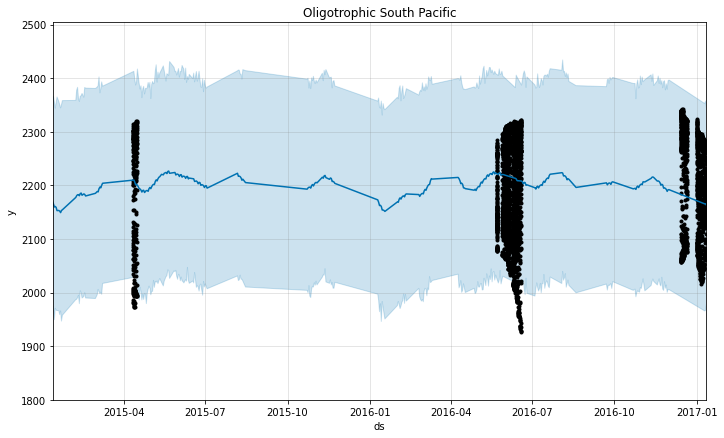

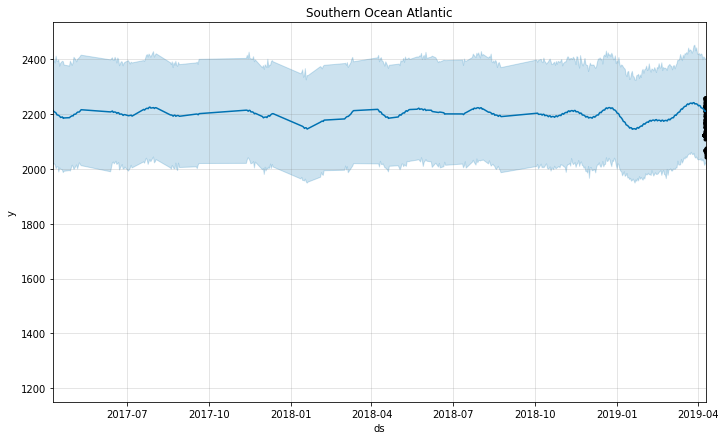

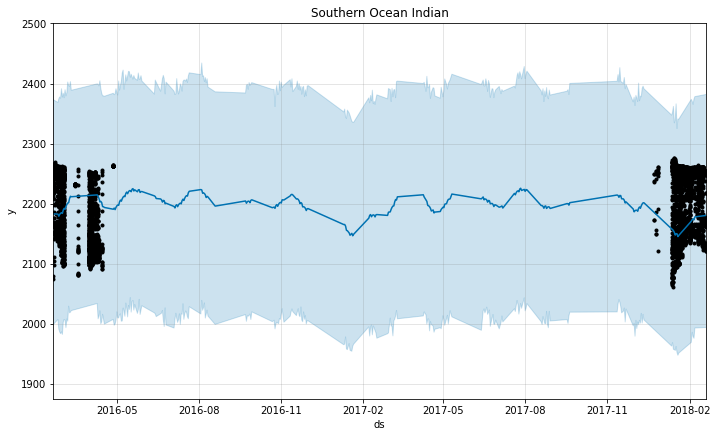

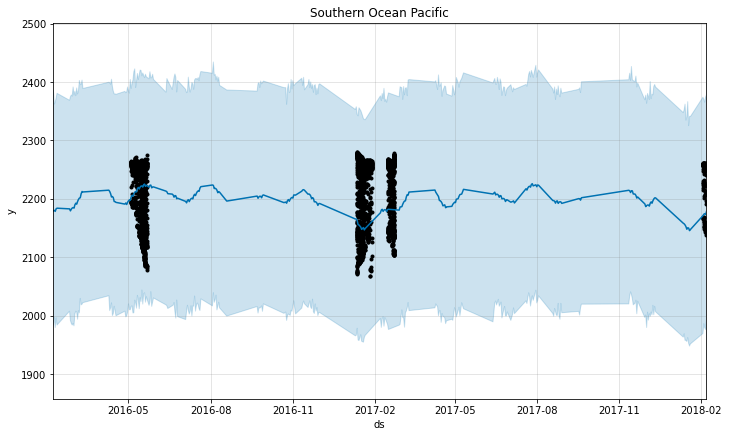

In [11]:
import seaborn as sns
import datetime
from fbprophet.plot import add_changepoints_to_plot
for key in futures.keys():  
  #fig, ax = plt.subplots()
  fig = models[key].plot(futures[key])
 # i.get_group(group)['ds'].max())
  edate= i.get_group(key)['ds'].max()
  ax = fig.gca();ax.set_xlim(pd.to_datetime([edate- datetime.timedelta(days=2*365) ,edate])) 
  ax.set_title(key)
  #a = add_changepoints_to_plot(fig.gca(), models[key], futures[key])

In [ ]:
# Python
from fbprophet.plot import plot_plotly, plot_components_plotly
li=list(futures.keys())
#for key in forecast.keys():
plot_plotly(models[li[2]], futures[li[2]])